Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


Load the processed data

df = pd.read_csv("../data/processed/processed-data.csv")

print("Shape:", df.shape)
df.head()

Time Feature Engineering

df['hour'] = (
    df['arrival_time']
    .astype(str)
    .str.split(':')
    .str[0]
    .astype(int)
    % 24
)

df['day_of_week'] = (
    df[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']]
    .idxmax(axis=1)
)

df['is_weekend'] = df['day_of_week'].isin(['saturday', 'sunday']).astype(int)

df[['hour','day_of_week','is_weekend']].head()


Peak hour feature

df['is_peak_hour'] = df['hour'].apply(
    lambda h: 1 if (8 <= h <= 10 or 17 <= h <= 20) else 0
)

Train Frequency

train_freq = (
    df.groupby(['stop_id', 'hour'])
    .agg(trains_per_hour=('trip_id', 'nunique'))
    .reset_index()
)

df = df.merge(train_freq, on=['stop_id', 'hour'], how='left')

df['trains_per_hour'] = df['trains_per_hour'].fillna(1)


Estimated Demand

np.random.seed(42)

df['estimated_demand'] = (
    500 +                         
    df['is_peak_hour'] * 2500 +  
    df['trains_per_hour'] * 200   
)

df['estimated_demand'] = df['estimated_demand'].clip(lower=5)
df.isna().sum()



Preprocessed data

features = [
    'hour',
    'is_weekend',
    'is_peak_hour',
    'trains_per_hour',
    'direction_id'
]

X = df[features].fillna(0)
y = df['estimated_demand'].fillna(df['estimated_demand'].mean())

Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Model Training

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)


Evaluate the model

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", round(mae, 2))


Feature Importance

importances = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)

importances.plot(
    kind='bar',
    title='Feature Importance for Passenger Demand Forecasting'
)
plt.show()


Demo Forecast

sample_input = pd.DataFrame([{
    'hour': 9,
    'is_weekend': 0,
    'is_peak_hour': 1,
    'trains_per_hour': 6,
    'direction_id': 0
}])

predicted_demand = model.predict(sample_input)
print("Predicted Passenger Demand:", int(predicted_demand[0]))


Exporting the model

import joblib

joblib.dump(model, "../model/demand_forecast_model.pkl")

joblib.dump(features, "../model/model_features.pkl")


Dataset Shape: (10726, 18)
Demand Forecast MAE: 82.44


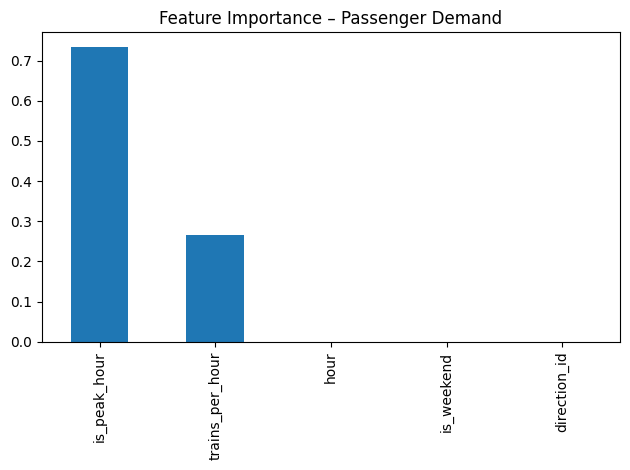


--- AI Scheduling Decision ---
Predicted Demand: 7386
Optimal Trains / Hour: 4
Recommended Headway (min): 15

Model and features saved successfully.


: 

In [ ]:
# =========================================================
# 1. IMPORTS
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from scipy.optimize import minimize
import joblib


# =========================================================
# 2. LOAD PROCESSED DATA
# =========================================================
df = pd.read_csv("../data/processed/processed-data.csv")

print("Dataset Shape:", df.shape)


# =========================================================
# 3. TIME FEATURE ENGINEERING
# =========================================================

# Extract hour from GTFS arrival_time
df['hour'] = (
    df['arrival_time']
    .astype(str)
    .str.split(':')
    .str[0]
    .astype(int)
    % 24
)

# Extract day of week from GTFS calendar flags
df['day_of_week'] = (
    df[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']]
    .idxmax(axis=1)
)

# Weekend flag
df['is_weekend'] = df['day_of_week'].isin(['saturday', 'sunday']).astype(int)

# Peak hour definition
df['is_peak_hour'] = df['hour'].apply(
    lambda h: 1 if (8 <= h <= 10 or 17 <= h <= 20) else 0
)


# =========================================================
# 4. SERVICE FREQUENCY FEATURE
# =========================================================
train_freq = (
    df.groupby(['stop_id', 'hour'])
    .agg(trains_per_hour=('trip_id', 'nunique'))
    .reset_index()
)

df = df.merge(train_freq, on=['stop_id', 'hour'], how='left')
df['trains_per_hour'] = df['trains_per_hour'].fillna(1)


# =========================================================
# 5. SYNTHETIC DEMAND GENERATION (FOR MODEL TRAINING)
# =========================================================
np.random.seed(42)

df['estimated_demand'] = (
    500 +
    df['is_peak_hour'] * 2500 +
    df['trains_per_hour'] * 200 +
    np.random.normal(0, 100, len(df))
)

df['estimated_demand'] = df['estimated_demand'].clip(lower=50)


# =========================================================
# 6. MODEL TRAINING (DEMAND FORECASTING)
# =========================================================
features = [
    'hour',
    'is_weekend',
    'is_peak_hour',
    'trains_per_hour',
    'direction_id'
]

X = df[features].fillna(0)
y = df['estimated_demand']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=150,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print("Demand Forecast MAE:", round(mae, 2))


# =========================================================
# 7. FEATURE IMPORTANCE (MODEL EXPLAINABILITY)
# =========================================================
pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False).plot(
    kind='bar',
    title='Feature Importance – Passenger Demand'
)

plt.tight_layout()
plt.show()


# =========================================================
# 8. OPTIMIZATION MODULE (CORE ADDITION)
# =========================================================

def optimize_trains(predicted_demand):
    """
    Optimization objective:
    Minimize passenger waiting time + operational cost
    """

    def objective(x):
        trains = x[0]

        # Passenger waiting proxy (higher trains → less waiting)
        waiting_cost = predicted_demand / trains

        # Operational cost (energy, staff, wear)
        operational_cost = trains * 1200

        # Weighted objective
        return 0.7 * waiting_cost + 0.3 * operational_cost

    # Constraints: 2 ≤ trains_per_hour ≤ 10
    bounds = [(2, 10)]

    result = minimize(
        objective,
        x0=[4],
        bounds=bounds,
        method='L-BFGS-B'
    )

    return int(round(result.x[0]))


# =========================================================
# 9. SAMPLE PREDICTION + OPTIMAL SCHEDULING
# =========================================================
sample_input = pd.DataFrame([{
    'hour': 9,
    'is_weekend': 0,
    'is_peak_hour': 1,
    'trains_per_hour': 4,
    'direction_id': 0
}])

predicted_demand = model.predict(sample_input)[0]
optimal_trains = optimize_trains(predicted_demand)

headway_minutes = int(60 / optimal_trains)

print("\n--- AI Scheduling Decision ---")
print("Predicted Demand:", int(predicted_demand))
print("Optimal Trains / Hour:", optimal_trains)
print("Recommended Headway (min):", headway_minutes)


# =========================================================
# 10. SAVE MODELS FOR STREAMLIT
# =========================================================
joblib.dump(model, "../model/demand_forecast_model.pkl")
joblib.dump(features, "../model/model_features.pkl")

print("\nModel and features saved successfully.")
